[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(38321, 2)
30656 3832 3832


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 432 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.730     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

KeyError: ignored

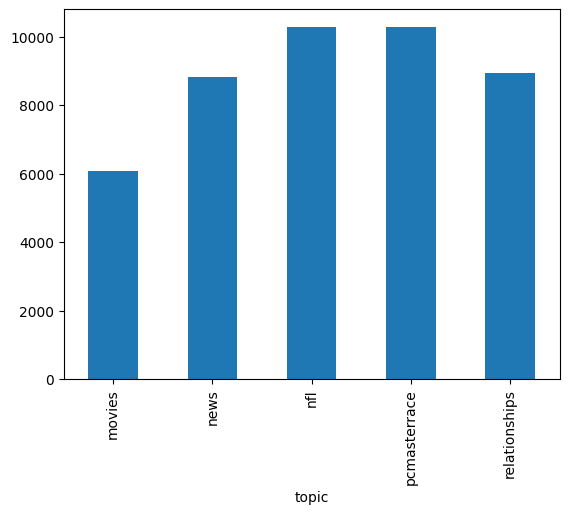

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.downloader
from sklearn.metrics import f1_score



class Textpreprocessing:
  def __init__(self,text):
    self.text=text

  def words(self,str1):
    tokens=str1.split()[:4]
    str2=''

    for i in range(len(tokens)):
      if i==0:
        str2+=tokens[i]
      else:
        str2=str2+" "+tokens[i]

    return str2



  def stopword_remove(self,str1):
    str1=str1.lower()
    tokens=str1.split()
    str2=""
    stop_words=stopwords.words('english')
    for word in tokens:
      if not word in stop_words:
        str2+=word+' '
    return str2

  def url_remove(self,str1):
    str1=re.sub(r'http\S+', '', str1)
    str1=re.sub(r'www\S+', '', str1)
    return str1

  def clean_punctuation(self,str1):
    str1=re.sub(r'[^\w\s]','',str1)
    return str1

  def cleaningdigits(self,str1):
    str1=re.sub(r'[\d+]','',str1)
    return str1

  def lemmatization(self,str1):
    lemma=WordNetLemmatizer()
    str2=''
    tokens=str1.split()
    for word in tokens:
      store=lemma.lemmatize(word)
      str2+=store+' '
    return str2

  def preprocess(self):
    self.text=self.text.apply(self.words)
    self.text=self.text.apply(self.stopword_remove)
    self.text=self.text.apply(self.url_remove)
    self.text=self.text.apply(self.clean_punctuation)
    self.text=self.text.apply(self.cleaningdigits)
    self.text=self.text.apply(self.lemmatization)

    return self.text


url='https://drive.google.com/file/d/12bhIJ9uIO4npZzq9Y4xt15WvZme6p9zn/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)



df.drop('parent_id',inplace=True,axis=1)
df.drop('length',inplace=True,axis=1)
df.drop('size_range',inplace=True,axis=1)
df=df.drop_duplicates()

df=df[df['text'].notnull()]
df=df[df['topic'].notnull()]


print(df.shape)

text_preprocess=Textpreprocessing(df['text'])
df['text']=text_preprocess.preprocess()
document_size=len(df)

df.groupby(['topic']).size().plot.bar()
df['topic']=df['topic'].astype('str')

df.groupby(['topic']).size()

df.drop(df.loc[df['topic']=='48'].index, inplace=True)

df.groupby(['topic']).size().plot.bar()

#change glove overall
new_model=gensim.downloader.load('glove-twitter-25')
new_model.most_similar("bad")
wv_size=len(new_model['bad'])


def create_word2vec_for_setence(text,max_word):

  results  = np.zeros(shape = (max_word,wv_size))
  #for i, documents in enumerate(text):
  for j, considered_word in list(enumerate(text.split())):
    try:
      results[j, :] = new_model[considered_word]
    except:
      results[j,:]=np.zeros((wv_size))
  return torch.tensor(results,dtype=torch.float32)


labels = {'movies':0,
          'news':1,
          'nfl':2,
          'pcmasterrace':3,
          'relationships':4
          }

class Dataset(Dataset):
  def __init__(self,df):

    self.labels=[labels[label] for label in df['topic']]
    self.texts=[create_word2vec_for_setence(text,512) for text in df['text']]



  def classes(self):
      return self.labels

  def __len__(self):
      return len(self.labels)

  def get_batch_labels(self, idx):
      # Fetch a batch of labels
      return np.array(self.labels[idx])

  def get_batch_texts(self, idx):
      # Fetch a batch of inputs
      return self.texts[idx]

  def __getitem__(self, idx):

      batch_texts = self.get_batch_texts(idx)
      batch_y = self.get_batch_labels(idx)

      return batch_texts, batch_y


np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))


!pip install labml-nn

import torch
from torch import nn
from labml.logger import inspect
from labml_nn.transformers.mha import MultiHeadAttention

def shift_right(x: torch.Tensor):
  zero_pad = x.new_zeros(x.shape[0], 1, *x.shape[2:])
  x_padded = torch.cat([x, zero_pad], dim=1)
  x_padded = x_padded.view(x.shape[1] + 1, x.shape[0], *x.shape[2:])
  x = x_padded[:-1].view_as(x)
  return x

class RelativeMultiHeadAttention(MultiHeadAttention):
  def __init__(self, heads: int, d_model: int, dropout_prob: float = 0.1):
    super().__init__(heads, d_model, dropout_prob, bias=False)
    self.P = 2 ** 12
    self.key_pos_embeddings = nn.Parameter(torch.zeros((self.P * 2, heads, self.d_k)), requires_grad=True)
    self.key_pos_bias = nn.Parameter(torch.zeros((self.P * 2, heads)), requires_grad=True)
    self.query_pos_bias = nn.Parameter(torch.zeros((heads, self.d_k)), requires_grad=True)
  def get_scores(self, query: torch.Tensor, key: torch.Tensor):
    key_pos_emb = self.key_pos_embeddings[self.P - key.shape[0]:self.P + query.shape[0]]
    key_pos_bias = self.key_pos_bias[self.P - key.shape[0]:self.P + query.shape[0]]
    query_pos_bias = self.query_pos_bias[None, None, :, :]
    ac = torch.einsum('ibhd,jbhd->ijbh', query + query_pos_bias, key)
    b = torch.einsum('ibhd,jhd->ijbh', query, key_pos_emb)
    d = key_pos_bias[None, :, None, :]
    bd = shift_right(b + d)
    bd = bd[:, -key.shape[0]:]
    return ac + bd
  def _test_shift_right():
    def _test_shift_right():
      x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
      inspect(x)
      inspect(shift_right(x))
      x = torch.arange(1, 6)[None, :, None, None].repeat(5, 1, 1, 1)
      inspect(x[:, :, 0, 0])
      inspect(shift_right(x)[:, :, 0, 0])
      x = torch.arange(1, 6)[None, :, None, None].repeat(3, 1, 1, 1)
      inspect(x[:, :, 0, 0])
      inspect(shift_right(x)[:, :, 0, 0])


import torch
from torch import nn as nn

from labml_helpers.module import Module


class FeedForward(Module):
    """
    ## FFN module
    """

    def __init__(self, d_model: int, d_ff: int,
                 dropout: float = 0.1,
                 activation=nn.ReLU(),
                 is_gated: bool = False,
                 bias1: bool = True,
                 bias2: bool = True,
                 bias_gate: bool = True):
        """
        * `d_model` is the number of features in a token embedding
        * `d_ff` is the number of features in the hidden layer of the FFN
        * `dropout` is dropout probability for the hidden layer
        * `is_gated` specifies whether the hidden layer is gated
        * `bias1` specified whether the first fully connected layer should have a learnable bias
        * `bias2` specified whether the second fully connected layer should have a learnable bias
        * `bias_gate` specified whether the fully connected layer for the gate should have a learnable bias
        """
        super().__init__()
        # Layer one parameterized by weight $W_1$ and bias $b_1$
        self.layer1 = nn.Linear(d_model, d_ff, bias=bias1)
        # Layer one parameterized by weight $W_1$ and bias $b_1$
        self.layer2 = nn.Linear(d_ff, d_model, bias=bias2)
        # Hidden layer dropout
        self.dropout = nn.Dropout(dropout)
        # Activation function $f$
        self.activation = activation
        # Whether there is a gate
        self.is_gated = is_gated
        if is_gated:
            # If there is a gate the linear layer to transform inputs to
            # be multiplied by the gate, parameterized by weight $V$ and bias $c$
            self.linear_v = nn.Linear(d_model, d_ff, bias=bias_gate)

    def forward(self, x: torch.Tensor):
        # $f(x W_1 + b_1)$
        g = self.activation(self.layer1(x))
        # If gated, $f(x W_1 + b_1) \otimes (x V + b) $
        if self.is_gated:
            x = g * self.linear_v(x)
        # Otherwise
        else:
            x = g
        # Apply dropout
        x = self.dropout(x)
        # $(f(x W_1 + b_1) \otimes (x V + b)) W_2 + b_2$ or $f(x W_1 + b_1) W_2 + b_2$
        # depending on whether it is gated
        return self.layer2(x)

from typing import List, Optional

import torch
import torch.nn as nn

from labml_helpers.module import Module
from labml_nn.utils import clone_module_list


class TransformerXLLayer(Module):
  def __init__(self, *,d_model: int,self_attn: RelativeMultiHeadAttention,feed_forward: FeedForward,dropout_prob: float):
    super().__init__()
    self.size = d_model
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.dropout = nn.Dropout(dropout_prob)
    self.norm_self_attn = nn.LayerNorm([d_model])
    self.norm_ff = nn.LayerNorm([d_model])
  def forward(self, *,x: torch.Tensor,mem: Optional[torch.Tensor],mask: torch.Tensor):
    z = self.norm_self_attn(x)
    if mem is not None:
      mem = self.norm_self_attn(mem)
      m_z = torch.cat((mem, z), dim=0)
    else:
      m_z = z
    self_attn = self.self_attn(query=z, key=m_z, value=m_z, mask=mask)
    x = x + self.dropout(self_attn)
    z = self.norm_ff(x)
    ff = self.feed_forward(z)
    x = x + self.dropout(ff)
    return x

class TransformerXL(Module):
  def __init__(self, layer: TransformerXLLayer, n_layers: int):
    super().__init__()
    self.layers = clone_module_list(layer, n_layers)
    self.norm = nn.LayerNorm([layer.size])
  def forward(self, x: torch.Tensor, mem: List[torch.Tensor], mask: torch.Tensor):
    new_mem = []
    for i, layer in enumerate(self.layers):
      new_mem.append(x.detach())
      m = mem[i] if mem else None
      x = layer(x=x, mem=m, mask=mask)
    return self.norm(x), new_mem

from torch import nn
import torch

class Transformer(nn.Module):
    def __init__(self, dropout=0.9, input_dim=25, hidden_dim=10):
        super(Transformer, self).__init__()

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(input_dim, 5)
        self.relu = nn.ReLU()

        # Initialize Transformer-XL
        d_model = input_dim  # Set the model dimensionality to the input dimension
        self.layer = TransformerXLLayer(
            d_model=d_model,
            self_attn=RelativeMultiHeadAttention(d_model=d_model,heads=1),
            feed_forward=FeedForward(d_model=d_model, d_ff=hidden_dim),
            dropout_prob=dropout
        )
        self.transformer_xl = TransformerXL(layer=self.layer, n_layers=1)

    def forward(self, x):
        pooled_output = x
        #mean_pooled_output = torch.mean(pooled_output, dim=1)
        #dropout_output = self.dropout(mean_pooled_output)
        dropout_output = self.dropout(pooled_output)

        # Apply Transformer-XL
        mem = []  # Initialize an empty memory list
        mask = None  # You can define the mask based on your specific requirements
        transformer_output, mem = self.transformer_xl(dropout_output, mem, mask)
        mean_transformer_output = torch.mean(transformer_output, dim=1)
        linear_output = self.linear(mean_transformer_output)
        final_layer = self.relu(linear_output)

        return final_layer



!pip install pytorch-lightning
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

class TextClassificationModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate

        # Define your model architecture
        self.model = Transformer(dropout=0.9, input_dim=input_dim, hidden_dim=hidden_dim)

        # Define your loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Prepare the data
train_loader = torch.utils.data.DataLoader(df_train, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(df_val, batch_size=128)
test_loader = torch.utils.data.DataLoader(df_test,batch_size=128)
# Initialize the Lightning module
model = TextClassificationModel(input_dim=25, hidden_dim=10, learning_rate=0.001)

# Initialize the Lightning Trainer
trainer = pl.Trainer(gpus=-1,auto_select_gpus=True, max_epochs=10, progress_bar_refresh_rate=20)

# Train the model
trainer.fit(model, train_loader, val_loader)

trainer.test(test_loader)